# Learning Curves of Lucie-7B

### 1. Load all benchmark results

Load CSV files ([evaluation_learning_curve_lucie.csv](evaluation_learning_curve_lucie.csv) and [evaluation_baselines.csv](evaluation_baselines.csv)).

In [ ]:
# !pip install pandas matplotlib seaborn python-slugify
 
import pandas as pd

lucie_results = pd.read_csv(
    "evaluation_learning_curve_lucie.csv"
)
baseline_results = pd.read_csv(
    "evaluation_baselines.csv"
)

# Print some statistics
def unique(field): return len(lucie_results[field].unique())
print(f"✅ {unique('training_tokens')} Lucie checkpoints evaluated on {unique('benchmark')} benchmarks ({unique('dataset')} datasets)")
def unique(field): return len(baseline_results[field].unique())
print(f"✅ {unique('model_name')} baseline checkpoints evaluated on {unique('benchmark')} benchmarks ({unique('dataset')} datasets)")

✅ 31 Lucie checkpoints evaluated on 6 benchmarks (228 datasets)
✅ 6 baseline checkpoints evaluated on 6 benchmarks (184 datasets)


### 2. Setup a plot config (and some normalization of model/dataset names)

In the code cell below, `benchmarks` must be a dictionary:
* key: the name of the benchmark (will be plotted as a title)
* values: a list of dataset names that will be plotted together (see column `dataset` of [the CSV file](evaluation_learning_curve_lucie.csv))


In [ ]:
# What to plot
BENCHMARKS = {
    "benchmarks in English":
        [
            "arc_challenge",        "hellaswag",
            "mmlu_continuation",    "winogrande",
            "gsm8k",                "truthfulqa_mc2",
        ],
    "French Bench":
        [
            "french_bench_arc_challenge",   "french_bench_hellaswag",
            "french_bench_grammar",         "french_bench_vocab",
        ],
    "Multilingual ARC benchmark":
        [
            "arc_fr",   "arc_es",
            "arc_de",   "arc_it",
        ],
}

# Output folder to save figures
OUTPUT_FOLDER = "figs"


# Some niceties to normalize dataset names
def normalize_dataset_name(name):
    words = []
    _languages = {
        "fr": "French",
        "es": "Spanish",
        "de": "German",
        "it": "Italian",
        "en": "English",
    }
    for w in name.split("_"):
        if w in _languages:
            w = _languages[w]
        elif len(w) <= 2 or w in ["arc", "mmlu", "mmmlu", "mc2", "mc1"]:
            w = w.upper()
        else:
            w = w.replace("gsm", "GSM")
            w = w[0].upper() + w[1:]
        words.append(w)
    return " ".join(words)
    

# Some niceties to normalize baseline names
def normalize_baseline_name(name):
    name = name.replace("__", "/").split("/")[-1]
    for common in ["Bloom", "Croissant", "Pythia-6.9B", "Llama-3", "Mistral-7B", "Falcon-7B"]:
        if common.lower() in name.lower():
            return common
    return name


### 3. Plot the learning curves

Saving figs/learning-curve-evaluation-benchmarks-in-english.png...


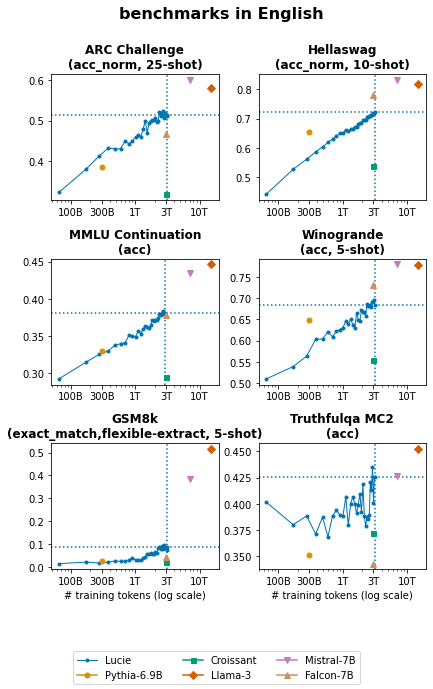

Saving figs/learning-curve-evaluation-french-bench.png...


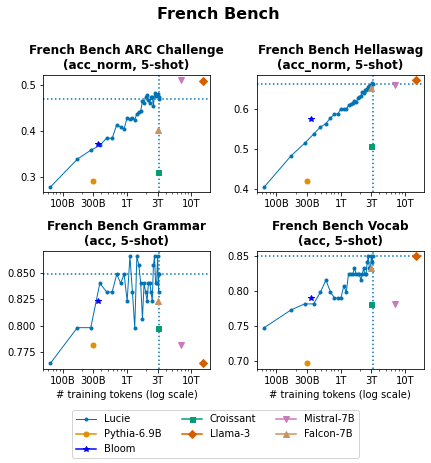

Saving figs/learning-curve-evaluation-multilingual-arc-benchmark.png...


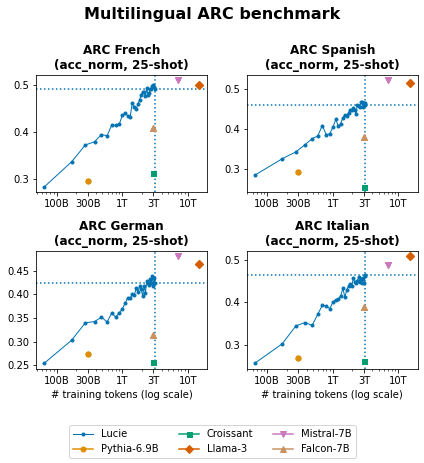

In [17]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import slugify


def plot_learning_curve(
        lucie_results,
        baseline_results,
        xlabel=True,
        xlogscale=True,
        use_lines=True,
        title=None,
    ):
    global _cached_baseline_indices
    if "_cached_baseline_indices" not in globals():
        _cached_baseline_indices = {}

    norm_tokens = 1e09 if not xlogscale else 1

    score_name = set(lucie_results["score_name"])
    assert len(score_name) == 1, f"Multiple score names found: {score_name}"
    score_name = list(score_name)[0]
    score_name = score_name.replace(",none", "")

    num_fewshot = set(lucie_results["num_fewshot"])
    num_fewshot = list(num_fewshot)[0]
    if num_fewshot:
        try:
            num_fewshot = int(num_fewshot)
        except Exception:
            num_fewshot = None

    # Set colorblind-friendly color palette
    color_palette = sns.color_palette("colorblind", n_colors=6)  # Colorblind-friendly palette
    lucie_color = color_palette[0]
    baseline_colors = color_palette[1:] + ['blue']
    baseline_markers = ['o', 's', 'D', 'v', '^', '*', 'o']  # Circle, Square, Diamond, Down-Triangle, Up-Triangle, Circle again
    baseline_markersizes = [5, 5, 5, 6, 6, 6, 6]  # Adjust sizes for each marker type
    max_styles = min(len(x) for x in (baseline_colors, baseline_markers, baseline_markersizes))
    
    # Lucie
    lucie_results = lucie_results.sort_values(by=["training_tokens", "score"], ascending=True)
    plt.plot(
        lucie_results['training_tokens'] / norm_tokens,
        lucie_results['score'],
        '.-',
        label='Lucie',
        color=lucie_color,
        linewidth=1
    )

    last_x = list(lucie_results['training_tokens'])[-1] / norm_tokens
    last_perf = list(lucie_results['score'])[-1]
    if use_lines:
        plt.axvline(x=last_x / norm_tokens, color=lucie_color, linestyle=':')  # Add vertical line
        plt.axhline(y=last_perf, color=lucie_color, linestyle=':')  # Add horizontal line
    else:
        plt.plot([last_x], [last_perf], "+", label=None, markersize=10, color=lucie_color)

    if xlogscale:
        plt.xscale('log')  # Set x-axis to log scale

        def can_be_rounded(x, ratio):
            return abs(x / ratio) % 1 <= 0.05
        def format_big_integer(x):
            assert norm_tokens == 1
            if x <= 1000: return str(int(x))
            if x <= 950_000 and can_be_rounded(x, 1000): return f"{x / 1_000:.0f}K"
            if x <= 950_000_000 and can_be_rounded(x, 1_000_000): return f"{x / 1_000_000:.0f}M"
            if x <= 950_000_000_000 and can_be_rounded(x, 1_000_000_000): return f"{x / 1_000_000_000:.0f}B"
            if x <= 950_000_000_000: return f"{x / 1_000_000_000:.1f}B"
            if can_be_rounded(x, 1_000_000_000_000): return f"{x / 1_000_000_000_000:.0f}T"
            return f"{x / 1_000_000_000_000:.1f}T"

        xticks_coordinates, _ = plt.xticks()
        previous = xticks_coordinates[0]
        new_xticks = [previous]
        for x in xticks_coordinates[1:]:
            if x / previous >= 10 - 1e-06:
                new_xticks.append(3 * previous)
            new_xticks.append(x)
            previous = x
        new_xticks_labels = [format_big_integer(x) for x in new_xticks]
        plt.xticks(new_xticks, new_xticks_labels)
        
    baseline_names = sorted(baseline_results["model_name"].unique())

    # Baselines with different colors, shapes, and adjusted marker sizes
    for name in baseline_names:
        if name in _cached_baseline_indices:
            idx = _cached_baseline_indices[name]
        else:
            idx = _cached_baseline_indices[name] = len(_cached_baseline_indices)
        if idx >= max_styles:
            raise RuntimeError(f"Not enought baseline styles (max {max_styles})!")
        marker = baseline_markers[idx]
        markersize = baseline_markersizes[idx]
        color = baseline_colors[idx]
        results = baseline_results[baseline_results["model_name"] == name]
        plt.plot(
            results['training_tokens'] / norm_tokens,
            results['score'],
            marker,
            label=normalize_baseline_name(name),
            markersize=markersize,
            color=color,
            linestyle=None
        )
    if xlabel:
        plt.xlabel("# training tokens" + (" (in billions)" if norm_tokens == 1e09 else (" (log scale)" if xlogscale else "")))

    if title is not False:
        if not title: title = ""
        else: title += "\n"
        title += f"({score_name}"
        if num_fewshot:
            title += f", {num_fewshot}-shot"
        title += ")"
        plt.title(title, weight='bold')

def plot_learning_curves_batch(
        lucie_results,
        baseline_results,
        benchmark_names,
        title=None,
        filename=None,
    ):

    ncols = min(2, len(benchmark_names))
    nrows = (len(benchmark_names) + 1) // ncols

    fig, ax = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3.5 * nrows))

    for i_bench, benchmark_name in enumerate(benchmark_names):
        plt.subplot(nrows, ncols, i_bench+1)
        lucie_selec = lucie_results[lucie_results["dataset"] == benchmark_name]
        baseline_selec = baseline_results[baseline_results["dataset"] == benchmark_name]
        assert len(lucie_selec) > 0, f"No results for Lucie for {benchmark_name}"
        assert len(baseline_selec) > 0, f"No baseline results for Lucie for {benchmark_name}"
        plot_learning_curve(
            lucie_selec, baseline_selec,
            xlabel=(i_bench >= ((len(benchmark_names) + 1) // 2) * 2 - 2),
            title=normalize_dataset_name(benchmark_name),
        )
        

    # Add the overall title with reduced spacing
    if title:
        plt.suptitle(title, fontsize=16, weight='bold', y=0.9)  # Reduce y value to bring the title closer

    # Adjust layout to add space for legend
    fig.subplots_adjust(bottom=0.2)

    # Set a single legend after the plots
    ax = plt.subplot(nrows, ncols, 1)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', fontsize=10, ncol=3)  # Legend after plots

    fig.tight_layout(rect=[0, 0.1, 1, 0.9])  # Adjust the plot to fit in the figure
    if filename:
        print(f"Saving {filename}...")
        plt.savefig(filename, facecolor='w', bbox_inches='tight')
    plt.show()


for title, dataset_names in BENCHMARKS.items():

    filename = None
    if OUTPUT_FOLDER:
        filename = os.path.join(OUTPUT_FOLDER, slugify.slugify(f"learning_curve_evaluation_{title}") + ".png")

    plot_learning_curves_batch(
        lucie_results,
        baseline_results,
        dataset_names,
        title=title,
        filename=filename,
    )